In [1]:
#### Testing ICP according to the tutorials
#### Non o3d.t version

In [2]:
import numpy as np
import open3d as o3d
import time
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def draw_registration_result(source, target, transformation):
    source_temp = o3d.t.geometry.PointCloud(source)
    target_temp = o3d.t.geometry.PointCloud(target)

    source_temp.transform(transformation)

    # This is patched version for tutorial rendering.
    # Use `draw` function for you application.
    
    o3d.visualization.draw_geometries(
        [source_temp.to_legacy(),
         target_temp.to_legacy()])

def draw_registration_result_forComparison(source, target, transformation1, transformation2):
    
    source_temp = o3d.t.geometry.PointCloud(source)
    source_temp.paint_uniform_color((1.0,.0,.0))
    
    source_temp2 = o3d.t.geometry.PointCloud()
    source_temp2.point.positions = copy.deepcopy(source_temp.point.positions)
    source_temp2.paint_uniform_color((.0,.0,0.0)) 
    
    source_temp.transform(transformation1)
    source_temp2.transform(transformation2)
    
    target_temp = o3d.t.geometry.PointCloud(target)
    target_temp.paint_uniform_color((.0,1.0,.0))

    # This is patched version for tutorial rendering.
    # Use `draw` function for you application.
    o3d.visualization.draw_geometries(
        [source_temp.to_legacy(), source_temp2.to_legacy(), target_temp.to_legacy()])

In [4]:
def gen_volumetric_weld_templates_by_params():
    x_min, x_max = -4.0, 4.0
    y_min, y_max = -12.0, 12.0
    z_min, z_max = -0.12, 0.2
    resolution = 0.3
    stem_x_min, stem_x_max = 1.8, 3.2
    stem_y_min, stem_y_max = -8.0, 8.0
    top_center_y = 7.5
    bottom_center_y = -7.5
    radius = 3.20
    
    def dist(pt1, pt2):
        x1, y1 = pt1
        x2, y2 = pt2
        dx = x2-x1
        dy = y2-y1
        return np.sqrt(dx**2 + dy**2)

    points2 = []
    
    for z in np.arange(z_min, z_max, resolution):
#     z = 0
        for x in np.arange(x_min, x_max, resolution):
            for y in np.arange(y_min, y_max, resolution):
                if dist((x,y), (0, top_center_y)) <= radius:
                    points2.append((x,y,z))
                elif dist((x,y), (0, bottom_center_y)) <= radius:
                    points2.append((x,y,z))
                elif stem_x_min<=x<=stem_x_max and stem_y_min<=y<=stem_y_max:
                    points2.append((x,y,z))

    points1 = [(-x, y, z) for x, y, z in points2]
    return {"[": points1, "]": points2}


In [5]:
## Inital PC coords
volumetric_templates = gen_volumetric_weld_templates_by_params()
pts1 = np.array(volumetric_templates["["])

## Creating Secondary PC Coords by Translating init
T = np.identity(4)
T[:, -1] = np.array([10,-10, 20, 1])
pts2 = np.ones((pts1.shape[0], 4))
pts2[:, :-1] = pts1[:, :]
pts2 = (T@pts2.T).T
pts2 = pts2[:, :3]

## Secondary Transformation mat to test viz
T2 = np.identity(4)
T2[:, -1] = np.array([11,-9, 21, 1])
T2 = o3d.core.Tensor(T2)

# 2 separate PC objects
pcdTarget = o3d.t.geometry.PointCloud()
pcdTarget.point.positions = o3d.core.Tensor(pts2)
pcdTarget.paint_uniform_color((.5, 0, 0))
# pcdTarget = pcdTarget.voxel_down_sample(0.8)

pcdTemplate = o3d.t.geometry.PointCloud()
pcdTemplate.point.positions = o3d.core.Tensor(pts1)
pcdTemplate.paint_uniform_color((0, 0, 0.5))
# pcdTemplate = pcdTemplate.voxel_down_sample(0.8)

## Duplicates to visualize the voxel downsizing
pcdTemplate_dup = o3d.t.geometry.PointCloud()
pcdTemplate_dup.point.positions = o3d.core.Tensor(pts1)
pcdTemplate_dup.paint_uniform_color((0, .5, 0.5))
pcdTemplate_dup = pcdTemplate_dup.voxel_down_sample(1)

pcdTarget_dup = o3d.t.geometry.PointCloud()
pcdTarget_dup.point.positions = o3d.core.Tensor(pts2)
pcdTarget_dup.paint_uniform_color((.5, .5, 0))
pcdTarget_dup = pcdTarget_dup.voxel_down_sample(1)

# o3d.visualization.draw_geometries(
#         [pcdTemplate.to_legacy(), pcdTemplate_dup.to_legacy(), pcdTarget_dup.to_legacy()])

In [6]:
# Search distance for Nearest Neighbour Search [Hybrid-Search is used].
max_correspondence_distance = 50

# Initial alignment or source to target transform.
init_source_to_target = np.identity(4)
init_source_to_target[:, -1] = np.array([9,-11, 20.5, 1])
init_source_to_target = o3d.core.Tensor(init_source_to_target)

# Select the `Estimation Method`, and `Robust Kernel` (for outlier-rejection).
estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPoint()

# Convergence-Criteria for Vanilla ICP
criteria = o3d.t.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.0000000001,
                                       relative_rmse=0.0000000000000000001,
                                       max_iteration=5000)

# Down-sampling voxel-size.
voxel_size = 0.5

# Save iteration wise `fitness`, `inlier_rmse`, etc. to analyse and tune result.
save_loss_log = True

# Example callback_after_iteration lambda function:
callback_after_iteration = lambda updated_result_dict : print("Iteration Index: {}, Fitness: {}, Inlier RMSE: {},".format(
    updated_result_dict["iteration_index"].item(),
    updated_result_dict["fitness"].item(),
    updated_result_dict["inlier_rmse"].item()))

In [7]:
s = time.time()

registration_icp =  o3d.t.pipelines.registration.icp(pcdTemplate, pcdTarget, max_correspondence_distance,
                            init_source_to_target, estimation, criteria, voxel_size,
                            callback_after_iteration=callback_after_iteration)

icp_time = time.time() - s
print("Time taken by ICP: ", icp_time)
print("Inlier Fitness: ", registration_icp.fitness)
print("Inlier RMSE: ", registration_icp.inlier_rmse)

Iteration Index: 0, Fitness: 1.0, Inlier RMSE: 0.5625738722177983,
Iteration Index: 1, Fitness: 1.0, Inlier RMSE: 0.470186367654889,
Iteration Index: 2, Fitness: 1.0, Inlier RMSE: 0.4124833330708608,
Iteration Index: 3, Fitness: 1.0, Inlier RMSE: 0.39798978718385775,
Iteration Index: 4, Fitness: 1.0, Inlier RMSE: 0.3979897871838574,
Iteration Index: 5, Fitness: 1.0, Inlier RMSE: 0.3979897871838572,
Iteration Index: 6, Fitness: 1.0, Inlier RMSE: 0.397989787183857,
Iteration Index: 7, Fitness: 1.0, Inlier RMSE: 0.39798978718385686,
Iteration Index: 8, Fitness: 1.0, Inlier RMSE: 0.39798978718385664,
Iteration Index: 9, Fitness: 1.0, Inlier RMSE: 0.39798978718385636,
Iteration Index: 10, Fitness: 1.0, Inlier RMSE: 0.3979897871838562,
Iteration Index: 11, Fitness: 1.0, Inlier RMSE: 0.3979897871838559,
Iteration Index: 12, Fitness: 1.0, Inlier RMSE: 0.39798978718385575,
Iteration Index: 13, Fitness: 1.0, Inlier RMSE: 0.3979897871838554,
Iteration Index: 14, Fitness: 1.0, Inlier RMSE: 0.39798

In [8]:
# draw_registration_result(pcdTemplate, pcdTarget, registration_icp.transformation)

In [9]:
draw_registration_result_forComparison(pcdTemplate, pcdTarget, registration_icp.transformation, init_source_to_target)

In [10]:
## Conclusion
# The od3.t provides as more functionality for registration
#  - namely specifying the convergence criteria, setting a callback function for post iteration

# Seeing the iterations through the print statements
# 0.5 Threshold, before seeing correspondeces when voxelized at 0.5

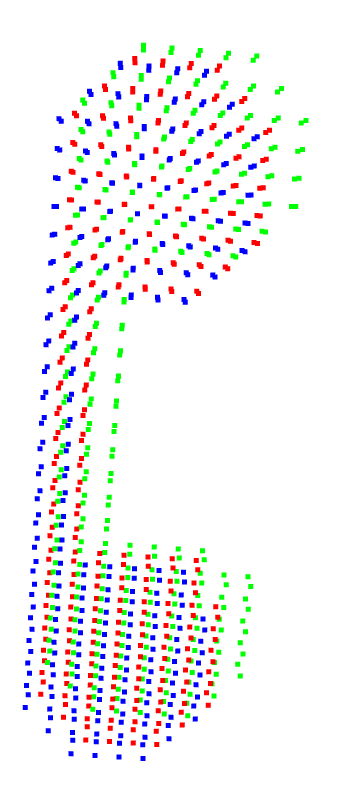

blue --> template after init transform; 
red --> template after icp; 
green --> target


Setting the criteria very tight: relative_fitness=0.0000000001, relative_rmse=0.0000000000000000001, max_iteration=5000


In [11]:
## Scanning the argument space on the ICP
#         args --> max_correspondence_distance, relative_fitness, relative_rmse, voxel_size

In [12]:
## A function to run through PointToPoint ICP by specifying 
    ## max_correspondence, voxel size, convergence criteria

def run_ICPPointToPoint(ptsTemplate, ptsTarget, init_transform, max_correspondence_distance, 
                        relative_fitness, relative_rmse, max_iteration, voxel_size ):
    """
    ptsTemplate: Nx3 numpy array 
    ptsTarget: Nx3 numpy array
    init_transform : 4x4 numpy
    max_correspondence_distance
    relative_fitness
    relative_rmse 
    max_iteration
    voxel_size 
    """
    # Convert arrays of point into PointCloud object
    pcdTarget = o3d.t.geometry.PointCloud()
    pcdTarget.point.positions = o3d.core.Tensor(ptsTarget)
    pcdTarget.paint_uniform_color((0.5, 0.0, 0.0))

    pcdTemplate = o3d.t.geometry.PointCloud()
    pcdTemplate.point.positions = o3d.core.Tensor(ptsTemplate)
    pcdTemplate.paint_uniform_color((0.0, 0.5, 0.0))
    
    # Convert initial transformation matrix into Tensor Object
    init_template_to_target = o3d.core.Tensor(init_transform)
    
    # Select the `Estimation Method`
    estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPoint()

    # Convergence-Criteria for Vanilla ICP
    criteria = o3d.t.pipelines.registration.ICPConvergenceCriteria(
        relative_fitness=relative_fitness, relative_rmse=relative_rmse, max_iteration=max_iteration)
    
    # Example callback_after_iteration lambda function:
    callback_after_iteration = lambda updated_result_dict : \
    print("Iteration Index: {}, Fitness: {}, Inlier RMSE: {},".format(
        updated_result_dict["iteration_index"].item(),
        updated_result_dict["fitness"].item(),
        updated_result_dict["inlier_rmse"].item()))
    
    # Starting registration measures
    registration_preicp = o3d.t.pipelines.registration.evaluate_registration(
        pcdTemplate, pcdTarget, max_correspondence_distance, init_template_to_target)
    
    # For measuring time for registration
    s = time.time()
    
    # Executing registration
    registration_icp =  o3d.t.pipelines.registration.icp(pcdTemplate, pcdTarget, max_correspondence_distance,
                                init_source_to_target, estimation, criteria, voxel_size,
                                callback_after_iteration=callback_after_iteration)
    # Time to convergence
    icp_time = time.time() - s
    
    return registration_preicp, registration_icp, icp_time

# reg_preicp, reg_icp, icp_time = run_ICPPointToPoint()